<a href="https://colab.research.google.com/github/megmarv/PsychoAI-/blob/Emotion-Identification4/ViTModel_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os
import zipfile

In [ ]:
# Unzip dataset
uploaded = files.upload()
zip_file = 'FER2013.zip'
extract_path = '/content/FER2013/'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Saving FER2013.zip to FER2013 (1).zip


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Enhanced ImageDataGenerator for training with more diverse augmentations
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,  # 20% of training data used for validation
    rotation_range=30,  # Increased rotation range
    width_shift_range=0.3,  # Allow more shifting
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,  # Adding vertical flip for diversity (if applicable)
    brightness_range=[0.8, 1.2],  # Adjust brightness
    channel_shift_range=0.1,  # Slightly shift color channels
    fill_mode='nearest'
)

# Validation generator (rescale only)
val_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2
)

# Enhanced Test Data Generator with minimal augmentation for real-world similarity
test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [ ]:
# Load training data
train_generator = train_datagen.flow_from_directory(
    os.path.join(extract_path, 'train'),  # Path to the train folder
    target_size=(48, 48),  # Resize images to 48x48
    batch_size=64,
    class_mode='categorical',  # Multi-class classification
    subset='training'  # Use the training subset
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    os.path.join(extract_path, 'train'),  # Path to the train folder
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',  # Multi-class classification
    subset='validation'  # Use the validation subset
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    os.path.join(extract_path, 'test'),  # Path to the test folder
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical'  # Multi-class classification
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Create the EfficientNetV2B0 model (pre-trained)
def create_model(input_shape=(48, 48, 3), num_classes=7):
    base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Create the model
model = create_model()

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up learning rate scheduler and early stopping
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 143s 351ms/step - accuracy: 0.2347 - loss: 1.8405 - val_accuracy: 0.2513 - val_loss: 1.8111 - learning_rate: 0.0010
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 120s 335ms/step - accuracy: 0.2513 - loss: 1.8156 - val_accuracy: 0.2513 - val_loss: 1.8096 - learning_rate: 0.0010
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 138s 384ms/step - accuracy: 0.2505 - loss: 1.8186 - val_accuracy: 0.2513 - val_loss: 1.8123 - learning_rate: 0.0010
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 121s 337ms/step - accuracy: 0.2569 - loss: 1.8135 - val_accuracy: 0.2513 - val_loss: 1.8161 - learning_rate: 0.0010
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 121s 336ms/step - accuracy: 0.2508 - loss: 1.8124 - val_accuracy: 0.2513 - val_loss: 1.8114 - learning_rate: 0.0010
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 121s 338ms/step - accuracy: 0.2527 - loss: 1.8134 - val_accuracy: 0.2513 - val_loss: 1.8098 - learning_rate: 5.0000e-04
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 121s 338ms/step - ac

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 202ms/step - accuracy: 0.2392 - loss: 1.8209
Test Loss: 1.8130724430084229, Test Accuracy: 0.24714405834674835


113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 279ms/step

Classification Report:
               precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.00      0.00      0.00      1024
       happy       0.25      1.00      0.40      1774
     neutral       0.00      0.00      0.00      1233
         sad       0.00      0.00      0.00      1247
    surprise       0.00      0.00      0.00       831

    accuracy                           0.25      7178
   macro avg       0.04      0.14      0.06      7178
weighted avg       0.06      0.25      0.10      7178



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


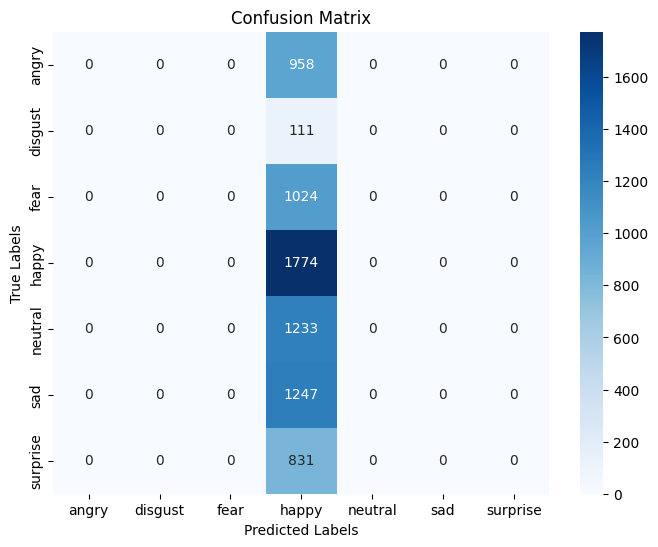


--- Evaluation Summary ---
Accuracy: 0.2471

Confusion Matrix:
 [[   0    0    0  958    0    0    0]
 [   0    0    0  111    0    0    0]
 [   0    0    0 1024    0    0    0]
 [   0    0    0 1774    0    0    0]
 [   0    0    0 1233    0    0    0]
 [   0    0    0 1247    0    0    0]
 [   0    0    0  831    0    0    0]]

--- Classification Report ---
               precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.00      0.00      0.00      1024
       happy       0.25      1.00      0.40      1774
     neutral       0.00      0.00      0.00      1233
         sad       0.00      0.00      0.00      1247
    surprise       0.00      0.00      0.00       831

    accuracy                           0.25      7178
   macro avg       0.04      0.14      0.06      7178
weighted avg       0.06      0.25      0.10      7178



In [ ]:
# Step 1: Get predictions from the model
test_predictions = model.predict(test_generator, verbose=1)
test_labels = test_generator.classes
predicted_labels = np.argmax(test_predictions, axis=1)

# Step 2: Import necessary libraries for evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 3: Generate confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Step 4: Calculate overall accuracy
accuracy = accuracy_score(test_labels, predicted_labels)

# Step 5: Generate classification report with F1 scores
report = classification_report(test_labels, predicted_labels, target_names=test_generator.class_indices.keys())
print("\nClassification Report:\n", report)

# Step 6: Generate confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Step 7: Display evaluation report
evaluation_report = {
    "Accuracy": accuracy,
    "Confusion Matrix": cm,
    "Classification Report": report
}

# Display evaluation summary
print("\n--- Evaluation Summary ---")
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", cm)
print("\n--- Classification Report ---\n", report)